In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import scipy.stats as st

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.font_manager
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from numpy import mean
from numpy import std

import xgboost as xgb

import pydotplus
import joblib

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


## 4. Regresión

Se busca predecir el valor del precio de las propiedades utilizando tres modelos diferentes.

Para tener una idea de criterio general de elección de variables que consideramos importantes para realizar las predicciones por medio de regresión, repasamos brevemente las correlaciones entre las mismas.

#### Ingeniería de características dataset completo

In [2]:
df_target = pd.read_csv('df_preprocesado.csv')
df_target_pca = pd.read_csv('df_pca.csv')

Obtenemos las features que van a ser utilizadas en la regresión

In [3]:
df_target = df_target.copy()[[
    'latitud',
    'longitud',
    'property_rooms',
    'property_bedrooms',
    'property_surface_total',
    'property_price',
    'property_surface_covered',
    'property_type'
    ]]


Convertimos la variable cualitatita "property_price" en forma numerica por medio de One Hot encoding

In [4]:
df_target = pd.get_dummies(df_target,columns=["property_type"],drop_first=True)

In [5]:
df_target.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_price,property_surface_covered,property_type_Departamento,property_type_PH
0,-34.637319,-58.361124,3.0,2.0,58.000000,82900.0,55.0,1,0
1,-34.628647,-58.361871,4.0,3.0,70.000000,99000.0,70.0,1,0
2,-34.610027,-58.401934,4.0,2.0,124.408727,146000.0,104.0,1,0
3,-34.631621,-58.416825,4.0,2.0,97.673080,250000.0,73.0,0,1
4,-34.623886,-58.412746,2.0,1.0,61.000000,100000.0,46.0,0,1


Separamos los nombres de las features regresoras del target (precio)

In [6]:
features_regresoras = list(df_target.columns)
features_regresoras.remove('property_price')
print(features_regresoras)

['latitud', 'longitud', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_type_Departamento', 'property_type_PH']


#### Separamos los datos en train y test. Tambien aplicamos un escalado sobre los datos

In [7]:
#selecciono variables regresoras y a predecir
X = df_target[features_regresoras].values
y = df_target.property_price

#Separacion Train/test  (80/20)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

#Escalamos los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Separacion de dataset de PCA en test y training

In [8]:
X_pca = df_target_pca.copy()
y_pca = df_target.property_price


# dividimos en train y test
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca,
                                                                    y_pca, 
                                                                    test_size=0.2,  #proporcion 80/20
                                                                    random_state=2) #semilla

# estandarizamos
scaler = MinMaxScaler()
scaler.fit(X_train_pca)
X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

### Modelo 1: KNN

#### Buscamos hiperparámetros con Random Search Cross Validation

In [9]:
#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {
    'leaf_size': list(range(1,40)),
    'n_neighbors': list(range(1,30)),
     'p': [1,2,3,4],
    'weights': ['uniform', 'distance']
}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

#Clasificador
knn_model = KNeighborsRegressor()

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=0) 

#Busco los hiperparamtros que optimizan R2 Score
randomcv.fit(X_train, y_train);

# Mejor métrica
print(randomcv.best_score_)

0.8831118416285062


In [10]:
params = randomcv.best_params_
print(params)

{'weights': 'distance', 'p': 2, 'n_neighbors': 28, 'leaf_size': 21}


#### Creamos el modelo, entrenamos y predecimos valores

In [11]:
knn_model = KNeighborsRegressor().set_params(**params)
knn_model.fit(X_train, y_train)

#Hago una predicción
y_pred = knn_model.predict(X_test)

#### Evaluamos metricas con el modelo evaluado en los datos de test

In [12]:
r2 = round(metrics.r2_score(y_test, y_pred), 4)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.8912
RMSE = 38731.7658


#### Evaluamos metricas con datos de train

In [13]:
y_train_pred = knn_model.predict(X_train)
r2 = round(metrics.r2_score(y_train, y_train_pred), 4)
rmse = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.9975
RMSE = 5813.5333


#### Realizamos el mismo desarrollo, ahora con el dataset de reduccion de dimensionalidad

#### Buscamos hiperparámetros con Random Search Cross Validation

In [14]:
#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {
    'leaf_size': list(range(1,40)),
    'n_neighbors': list(range(1,30)),
     'p': [1,2,3,4],
    'weights': ['uniform', 'distance']
}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

#Clasificador
knn_model_pca = KNeighborsRegressor()

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = knn_model_pca,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=0) 

#Busco los hiperparamtros que optimizan R2 Score
randomcv.fit(X_train_pca, y_train_pca);

# Mejor métrica
print(randomcv.best_score_)

0.7319386240633565


In [15]:
params = randomcv.best_params_
print(params)

{'weights': 'distance', 'p': 2, 'n_neighbors': 28, 'leaf_size': 21}


#### Creamos el modelo, entrenamos y predecimos valores

In [16]:
knn_model_pca = KNeighborsRegressor().set_params(**params)
knn_model_pca.fit(X_train_pca, y_train_pca)

KNeighborsRegressor(leaf_size=21, n_neighbors=28, weights='distance')

#### Evaluamos metricas con el modelo evaluado en los datos de test pca

In [17]:
y_pred_pca = knn_model_pca.predict(X_test_pca)
r2 = round(metrics.r2_score(y_test_pca, y_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_test_pca, y_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.7438
RMSE = 59436.3998


#### Evaluamos metricas con datos de train

In [18]:
y_train_pred_pca = knn_model_pca.predict(X_train_pca)
r2 = round(metrics.r2_score(y_train_pca, y_train_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_train_pca, y_train_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.9975
RMSE = 5837.625


#### Exportamos los modelos

In [19]:
joblib.dump(knn_model, 'regresor_knn.joblib')
joblib.dump(knn_model_pca, 'regresor_knn_PCA.joblib')

['regresor_knn_PCA.joblib']

### Modelo 2: XGBoost

#### Cargamos el dataset y lo preparamos para ser utilizado con el modelo

#### Buscamos hiperparámetros con Random Search Cross Validation

In [20]:
##KFOLD CV Random Search para buscar los mejores hiperparametros

#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros a usar
params_grid = {
                'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [0,1,2],
                'n_estimators': list(range(10,161,10))
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgboost = xgb.XGBRegressor(random_state=0) 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = xgboost,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=23) 

#Busco los hiperparametros que optimizan el R2 Score
randomcv.fit(X_train, y_train);

#Mejor métrica
print(randomcv.best_score_)

0.8677252735810617


In [21]:
params = randomcv.best_params_
print(params)

{'subsample': 0.6842105263157894, 'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.20612244897959187, 'lambda': 1, 'gamma': 1, 'alpha': 2}


#### Creamos el modelo, entrenamos y predecimos valores

In [22]:
#Creo el modelo y lo entreno
xgb_model = xgb.XGBRegressor(random_state=23).set_params(**params)
xgb_model.fit(X_train, y_train)

#Realizamos la predicción
y_pred = xgb_model.predict(X_test)

#### Evaluamos metricas con el modelo evaluado en los datos de test

In [23]:
r2 = round(metrics.r2_score(y_test, y_pred), 4)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.8782
RMSE = 40987.7925


De acuerdo al R2 score, que toma valores entre 0 y 1, siendo 1 que se ajusta perfectamente a los datos, podemos pensar que 0.8782 es un valor aceptablemente alto como para considerar el modelo como exitoso.

En cuanto al RMSE (raiz del error cuadratico medio) notamos que no es un valor tan bajo como esperariamos. Si observamos el grafico debajo, las zonas entre lineas rojas representan el ancho del error que se puede producir al predecir un valor, en promedio.

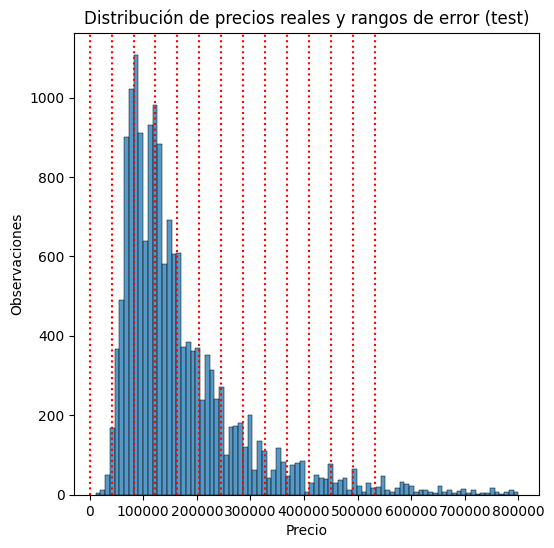

In [24]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_test)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (test)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

Realizamos el mismo grafico, con los precios de la predicción:

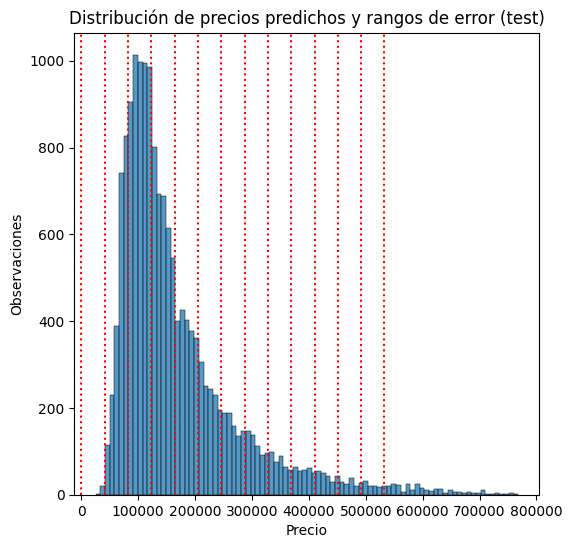

In [25]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_pred)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios predichos y rangos de error (test)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Evaluamos metricas con datos de train

In [26]:
y_train_pred = xgb_model.predict(X_train)
r2 = round(metrics.r2_score(y_train, y_train_pred), 4)
rmse = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.9066
RMSE = 35696.4882


Graficamos, como antes, solo para los valores reales el rango del error.

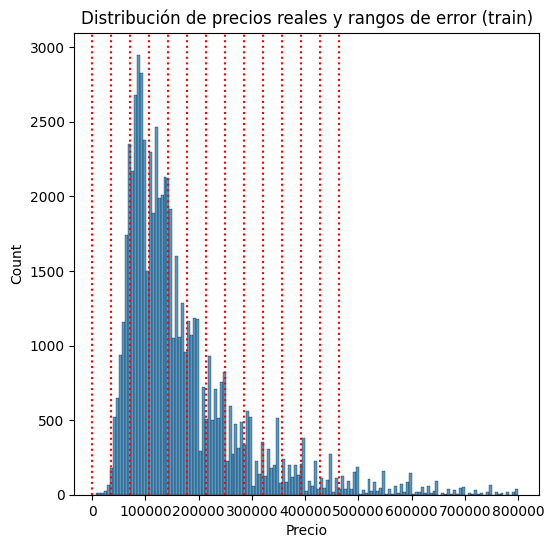

In [27]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_train)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (train)')
plt.xlabel('Precio')
plt.show()

#### Comparamos metricas de train con test

Podemos notar que las metricas son bastantes parecidas, lo cual habla bien del modelo. No podemos decir que generaliza muy mal a los datos ni tampoco decir que esta sobre ajustando a los mismos. Creemos que estamos en un buen equilibrio entre baja varianza y bajo bias.

Si fuese el caso de overfitting severo, veriamos métricas muy altas en train pero luego en test estas caerían bastante.

De todas formas se puede destacar una diferencia más notable en los scores R2, que podría llegar a considerarse un muy leve overfitting, pero no consideramos que afecte tanto dado que sigue obteniendose un resultado muy favorable.

#### Realizamos el mismo desarrollo, ahora con el dataset de reduccion de dimensionalidad

#### Buscamos optimizar hiperparámetros

In [28]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid_pca = {
                'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [0,1,2],
                'n_estimators': list(range(10,161,10))
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgboost = xgb.XGBRegressor(random_state=0) 

#Random Search Cross Validation
randomcv_pca = RandomizedSearchCV(estimator = xgboost,
                              param_distributions = params_grid_pca,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=23) 

#Busco los hiperparamtros que optimizan Accuracy Score
randomcv_pca.fit(X_train_pca, y_train_pca);

#Mejor métrica
print(randomcv_pca.best_score_)

0.6381069530640969


#### Creamos el modelo, entrenamos y predecimos valores

In [29]:
params = randomcv_pca.best_params_
xgb_model_pca = xgb.XGBRegressor(random_state=23).set_params(**params)
xgb_model_pca.fit(X_train_pca, y_train_pca)

y_pred_pca = xgb_model_pca.predict(X_test_pca)

#### Evaluamos métricas con las predicciones de test

In [30]:
r2 = round(metrics.r2_score(y_test_pca, y_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_test_pca, y_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.6602
RMSE = 68451.9171


#### Realizamos el mismo gráfico previo para entender el error

En esta oportunidad, las metricas con este dataset son similares a las del dataset original, por lo tanto el análisis de antes aplica a esta ocasión.

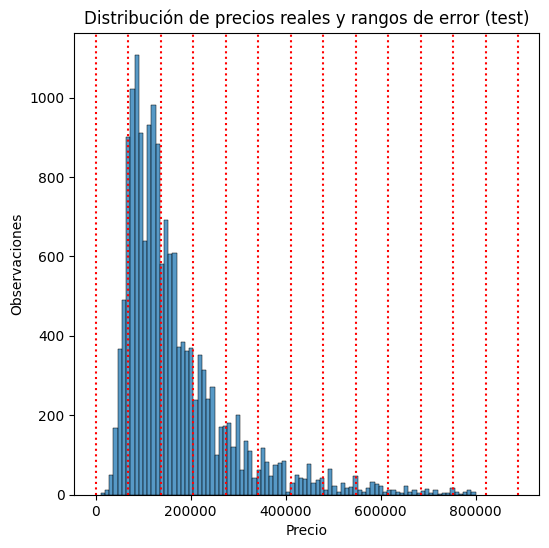

In [31]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_test_pca)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (test)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Evaluamos metricas con datos de train

In [32]:
y_train_pred_pca = xgb_model_pca.predict(X_train_pca)
r2 = round(metrics.r2_score(y_train_pca, y_train_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_train_pca, y_train_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.7266
RMSE = 61066.9188


Graficamos nuevamente con los datos de train

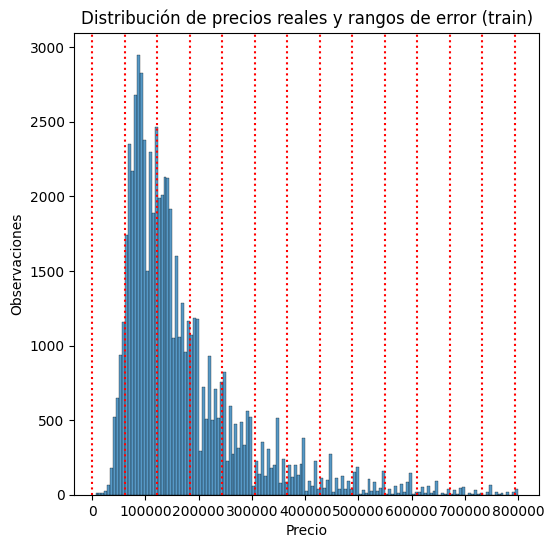

In [33]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_train_pca)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (train)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Comparación de ambos modelos (datasets Target vs PCA)

En esta ocasión los resultados de ambos modelos, uno entrenado con el dataset original y el otro con el dataset resultado de una reducción de la dimensionalidad, se vieron con grandes diferencias. El modelo que se entrena con los datos originales performa notablemente mejor que el otro entrenado con la dimension reducida. Esto se puede deber a que el dataset obtenido en el punto 1d) no sea muy bueno.

Los resultados de R2 y RMSE (los analizados para nuestros modelos de regresión) se vieron notablemente mas altos para el dataset original, tanto para train como test. A pesar de ser alto, no creemos que el modelo este sobreajustando, ya que como mencionamos, las métricas de test son altas.

El dataset redimensionado cuenta con una cantidad significativamente menor de features y es el resultado de la aplicación de otro algoritmo anterior. Por estas razones creemos que los resultados se pueden haber visto afectados a la hora de entrenar el modelo XGBoost.

Dados estos datos obtenidos de los dos modelos entrenados, vamos a considerar que nos conviene mas utilizar el primero entrenado con los datos originales.

#### Exportamos los dos modelos

In [34]:
joblib.dump(xgb_model, 'regresor_xgboost.joblib')
joblib.dump(xgb_model_pca, 'regresor_xgboost_PCA.joblib')

['regresor_xgboost_PCA.joblib']

### Modelo 3: Support Vector Machines  

Cabe tener en cuenta que para este modelo se especifíca en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) que el mismo no es muy recomendable para su aplicación en datasets con una gran cantidad de observaciones dada la complejidad computacional que se requiere para kernels no lineales. 

Si bien allí se recomendaba utilizar LinearSVR, decidimos proceder ***inicialmente*** con el modelo normal (SVR) para intentar aprovechar las capacidades que tiene SVM en cuanto a kernels disponibles sin limitarlo a obtener algo similar a la regresión lineal.

Esto fue modificado posteriormente en la notebook, donde se verá que se terminó utilizando la version LinearSVR (SVR con kernel lineal especialmente optimizado para datasets de gran tamaño) de scikit learn.
La explicación a detalle de esta decisión se verá más adelante.

#### Buscamos hiperparámetros con Random Search Cross Validation

Tras probar lo siguiente se observó que, tal como se indicó acerca de la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) de SVR, la obtención de hiperparametros adecuados tarda demasiado tiempo debido a la complejidad computacional que requiere el entrenamiento del modelo, dado por la gran cantidad de observaciones que tiene el dataset.

A raiz de esto se intentó forzar al uso de menos iteraciones por parte del modelo al entrenarse, seteando el parametro `max_iter` (y además se aumentó la RAM destinada a caché por parte del entrenamiento del modelo, con el parametro `cache_size`).

A pesar de todo esto, no se logró algo satisfactorio como se muestra a continuación:


In [35]:
#Cantidad de combinaciones a porbar
n=10

#Conjunto de parámetros a usar
params_grid = {
                'kernel': ['poly'],
                'degree': [5, 6 ,7, 8, 9] ,
                'gamma': ['scale', 'auto'],
                'coef0': [1],
                'C': [1, 0.75, 0.5],
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Regresor
svmReg = svm.SVR(cache_size=900, max_iter=1000) # El cache es para agilizar el procesado
# Ademas se limita a 1000 max iter dado que de otra forma el procesamiento tarda demasiado.

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = svmReg,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=0) 

#Busco los hiperparametros que optimizan R2 Score
randomcv.fit(X_train, y_train);

#Mejor métrica
print(randomcv.best_score_)

0.24867114423648892


In [36]:
randomcv.best_params_

{'kernel': 'poly', 'gamma': 'scale', 'degree': 7, 'coef0': 1, 'C': 0.5}

In [37]:
randomcv.cv_results_['mean_test_score']

array([  0.15197621, -34.33337536,  -1.02578843,  -0.64315237,
        -5.02355514,   0.24867114,  -1.02833261,  -1.02618263,
        -1.02735009,  -0.28541651])

Como se puede observar, forzar a que el modelo tenga una cantidad finita y fija relativamente baja (a comparacion de su parametro por defecto, que permite una cantidad infinita) de iteraciones causa un gran deterioro en el método y deja de ser de utilidad sin importar los hiperparametros que se prueben. 
(Dejamos seteado el parametro `max_iter` con valor de 1000 para agilizar, pero se puede cambiar ese valor para ver como aumenta el valor de la metrica hasta cierto punto a medida que se aumenta el mismo, pero a su vez aumenta en gran medida el tiempo de ejecución. Si no se setea el parametro y se le permite iteraciones infinitas, puede llegar a tardar como mínimo 3 horas, resultando en score aproximada de 0.56, por lo cual no vale la espera).

Teniendo todo lo anterior en cuenta decidimos proceder utilizando la version [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html), que si bien pierde la capacidad de elegir un kernel que no sea el lineal, es mucho más eficiente y logra resultados decentes como se muestra en lo que sigue.

In [38]:
#Cantidad de combinaciones de parametros a probar
n=10

#Conjunto de parámetros a usar
params_grid = {
                'C': [100, 10, 1, 0.75, 0.5],
                'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                'max_iter': [1000, 10000]
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Regresor
svmLReg = svm.LinearSVR(random_state=7) 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = svmLReg,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=0) 

#Busco los hiperparametros que optimizan R2 Score
randomcv.fit(X_train, y_train);

#Mejor métrica
print(randomcv.best_score_)

0.6864661995696115


In [39]:
params = randomcv.best_params_

In [40]:
params

{'max_iter': 1000, 'loss': 'squared_epsilon_insensitive', 'C': 1}

#### Creamos el modelo, entrenamos y predecimos valores

In [41]:
#Creo el modelo y lo entreno
svmr_model = svm.LinearSVR(random_state=7).set_params(**params)
svmr_model.fit(X_train, y_train)

y_pred = svmr_model.predict(X_test)

#### Evaluamos metricas con el modelo evaluado en los datos de test

In [42]:
r2 = round(metrics.r2_score(y_test, y_pred), 4)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.6971
RMSE = 64629.6133


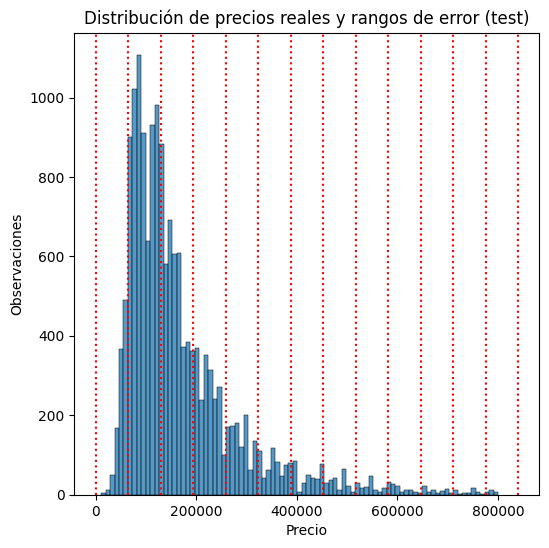

In [43]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_test)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (test)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Observamos lo mismo pero con los precios de la predicción

In [44]:
y_train_pred = svmr_model.predict(X_train)
r2 = round(metrics.r2_score(y_train, y_train_pred), 4)
rmse = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.6866
RMSE = 65380.0996


Graficamos, como antes, solo para los valores reales el rango del error.

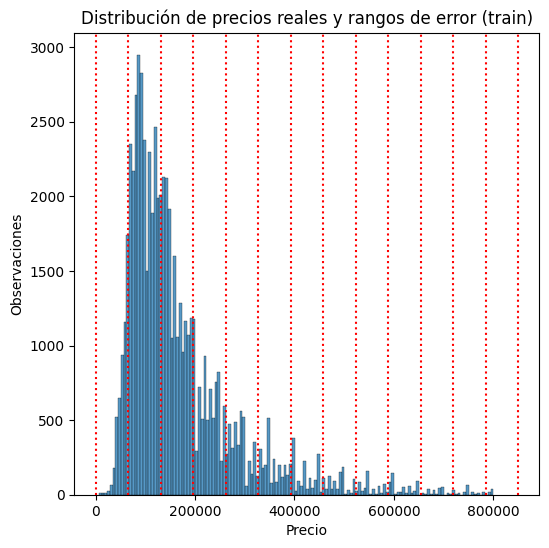

In [45]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_train)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (train)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Comparamos metricas de train con test

Nuevamente vemos que las métricas son similares tanto para las predicciones sobre los datos de test como para las hechas sobre datos de train, aunque con una diferencia levemente más notable en el score R2.

Como el cambio es del orden de 0.02, no consideramos que el modelo haya resultado con overfit, sigue siendo considerablemente aceptable el resultado.

Se destaca como en los otros modelos entrenados anteriormente que el RMSE sigue siendo más grande de lo que se desearía en las predicciones.

#### Repetimos el mismo desarrollo para el dataset de reduccion de dimensionalidad

#### Buscamos optimizar hiperparámetros

In [46]:
#Cantidad de combinaciones a porbar
n=10

#Conjunto de parámetros a usar
params_grid = {
                'C': [100, 10, 1, 0.75, 0.5],
                'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                'max_iter': [1000, 10000]
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Regresor
svmLReg = svm.LinearSVR(random_state=7)

#Random Search Cross Validation
randomcv_pca = RandomizedSearchCV(estimator = svmLReg,
                              param_distributions = params_grid,
                              scoring = 'r2',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=0) 

#Busco los hiperparamtros que optimizan Accuracy Score
randomcv_pca.fit(X_train_pca, y_train_pca);

#Mejor métrica
print(randomcv_pca.best_score_)

0.5188735614717548


In [47]:
params = randomcv_pca.best_params_

In [48]:
params

{'max_iter': 1000, 'loss': 'squared_epsilon_insensitive', 'C': 10}

#### Creamos el modelo, entrenamos y predecimos valores

In [49]:
svmr_model_pca = svm.LinearSVR(random_state=7).set_params(**params)
svmr_model_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = svmr_model_pca.predict(X_test_pca)

#### Evaluamos métricas con las predicciones de test

In [50]:
r2 = round(metrics.r2_score(y_test_pca, y_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_test_pca, y_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.5353
RMSE = 80051.8236


Realizamos el mismo gráfico previo para observar el error

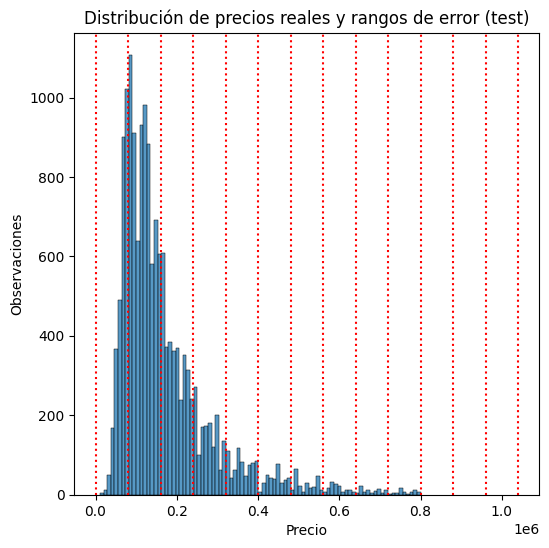

In [51]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_test_pca)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (test)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Evaluamos metricas con datos de train

In [52]:
y_train_pred_pca = svmr_model_pca.predict(X_train_pca)
r2 = round(metrics.r2_score(y_train_pca, y_train_pred_pca), 4)
rmse = round(metrics.mean_squared_error(y_train_pca, y_train_pred_pca, squared=False), 4)

print(f'R2 = {r2}')
print(f'RMSE = {rmse}')

R2 = 0.5189
RMSE = 81005.3262


Graficamos nuevamente con los datos de train

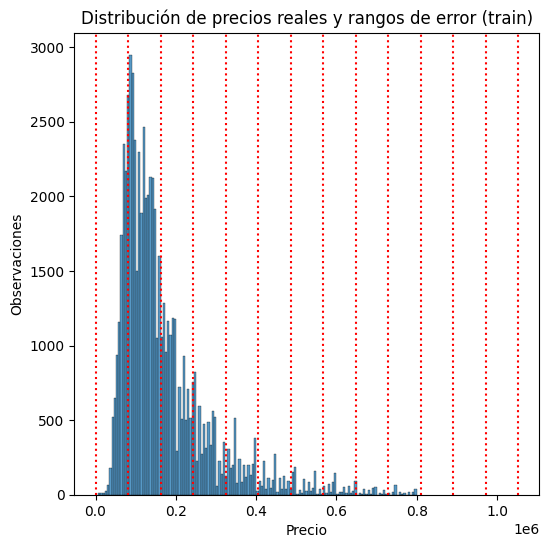

In [53]:
plt.figure(figsize=(6,6))
grf = sns.histplot(y_train_pca)
for i in range(14):
    grf.axvline(i*rmse, c='red', linestyle='dotted')
plt.title('Distribución de precios reales y rangos de error (train)')
plt.xlabel('Precio')
plt.ylabel('Observaciones')
plt.show()

#### Comparación de ambos modelos (datasets Target vs PCA)

Para el caso del modelo entrenado a partir del dataset original, se observa un resultado casi equivalente entre sus grupos de training y test, con lo cual el modelo generaliza bien para los datos en este escenario. Sin embargo el R2 es considerablemente menor al obtenido con los modelos anteriores (KNN y XGBoost), y el error a su vez es bastante mayor.

Para el caso del modelo entrenado a partir del dataset con PCA, se observa un desempeño mucho peor, y concluimos que aplicado sobre este dataset se tiene un underfitting muy marcado en general.

#### Exportamos los modelos

In [54]:
joblib.dump(svmr_model, 'regresor_SVM.joblib')
joblib.dump(svmr_model_pca, 'regresor_SVM_PCA.joblib')

['regresor_SVM_PCA.joblib']

### Elección de modelo para Regresión

Teniendo en cuenta todos los resultados de los modelos anteriores, en caso de tener que decidir por utilizar un modelo para la regresión de valores de precio de las propiedades, elegiríamos el **modelo 2: XGBoost**, dado que resultó ser el modelo con los mejores resultados. 

En general se observa en el mismo:
- Menor brecha del resultado de métricas entre aplicaciones del modelo en datos de train y test
- Menor valor del error RMSE entre todos los modelos
- Valor mucho más alto de score R2, representando una gran diferencia representando la variabilidad de los datos.
- Si bien puede existir un muy leve overfitting, los resultados anteriores siguen siendo muy positivos sobre la partición de test a comparación de los otros modelos.

---

## 5. Conclusiones

- A lo largo de este Trabajo Practico pudimos aplicar distintos metodos de preprocesamiento y analisis de valores atipicos . Pudimos trabajar en profundidad los conceptos de analisis e investigacion sobre las distintas propiedades de CABA y llegar asi a distintos modelos que predicen la categoria de precio y el valor del mismo. 
- Durante el desarrollo del mismo se fueron realizando las conclusiones más importantes que se pudieron obtener de cada una de las secciones particulares.
- Al momento de analizar los hiperparametros de los modelos en muchos casos nos encontramos frente a la situación de que algunos de los parametros se comportaban mejor cuando su valor era el predeterminado por la libreria y es por eso que no aparecia como una variante en el random search.
- Pudimos observar mejores resultados tanto analiticos como visuales para K-means usando como K=2 mas alla de que por el enunciado pudimos inferir que se esperaban un K mayor a 3.
- Uno de los temas que no fue analizado en este trabajo fue la utilizacion de redes neuronales para crear un modelo de prediccion no solo de forma categorica sino de forma regresivo/numerico, sino que se utilizaron arboles de decision , clusterizacion y otros metodos que implementan a estos. Por ejemplo , en el caso de los ensambles para XGBoost.
- Otra posible aplicación que no fue realizada en trabajo es la utilización de ensambles de tipo voting o stacking para multiples modelos de distinto tipo (Por ejemplo XGBoost utiliza stacking, pero lo hace a partir del mismo tipo de modelo).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7da1cea6-caf2-4c30-b019-068f1fb82c77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>